In [1]:
import numpy as np
import os
import pathlib
import tarfile
import mlutils
import cv2

from functools import partial

from data_loader import StanfordDogLoader

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
%matplotlib inline
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 18
})

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import preprocessing

SAVE_FIG = False

def save_fig(name, tight_layout = True):
    if SAVE_FIG:
        print(f"Saving figure {name} ...")
        if tight_layout:
            plt.tight_layout()
        plt.savefig(f"plots/{name}.pdf", backend="pgf")

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
loader = StanfordDogLoader()

train_ds_original, val_ds_original, test_ds_original = loader.load()

[INFO] Fetched 20580 images
[INFO] Found 120 classes
[INFO] The first ten classes are
['n02085620-Chihuahua' 'n02085782-Japanese_spaniel'
 'n02085936-Maltese_dog' 'n02086079-Pekinese' 'n02086240-Shih-Tzu'
 'n02086646-Blenheim_spaniel' 'n02086910-papillon' 'n02087046-toy_terrier'
 'n02087394-Rhodesian_ridgeback' 'n02088094-Afghan_hound']
[INFO] Image count per class
[152, 185, 252, 149, 214, 188, 196, 172, 172, 239, 175, 195, 187, 171, 159, 153, 157, 148, 151, 218, 182, 187, 188, 196, 151, 200, 232, 160, 155, 164, 182, 172, 179, 169, 172, 185, 164, 157, 197, 202, 202, 197, 196, 180, 182, 154, 157, 155, 158, 206, 183, 156, 169, 186, 152, 151, 150, 171, 167, 152, 154, 161, 155, 153, 152, 150, 159, 150, 159, 151, 150, 150, 154, 150, 150, 152, 153, 154, 169, 157, 153, 150, 150, 152, 152, 150, 184, 168, 218, 151, 202, 151, 156, 152, 159, 156, 170, 150, 178, 192, 150, 209, 200, 210, 195, 213, 218, 219, 196, 158, 153, 181, 155, 151, 155, 159, 155, 156, 150, 169]
[INFO] The dataset split is
- T

In [4]:
print(train_ds_original)
print(val_ds_original)
print(test_ds_original)
for img, label in test_ds_original.take(10):
    print(label)

<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
tf.Tensor(91, shape=(), dtype=int64)
tf.Tensor(119, shape=(), dtype=int64)
tf.Tensor(50, shape=(), dtype=int64)
tf.Tensor(57, shape=(), dtype=int64)
tf.Tensor(81, shape=(), dtype=int64)
tf.Tensor(103, shape=(), dtype=int64)
tf.Tensor(88, shape=(), dtype=int64)
tf.Tensor(109, shape=(), dtype=int64)
tf.Tensor(20, shape=(), dtype=int64)
tf.Tensor(63, shape=(), dtype=int64)


In [5]:
loader.norm_class_names[:10]

['Chihuahua',
 'Japanese spaniel',
 'Maltese dog',
 'Pekinese',
 'Shih',
 'Blenheim spaniel',
 'papillon',
 'toy terrier',
 'Rhodesian ridgeback',
 'Afghan hound']

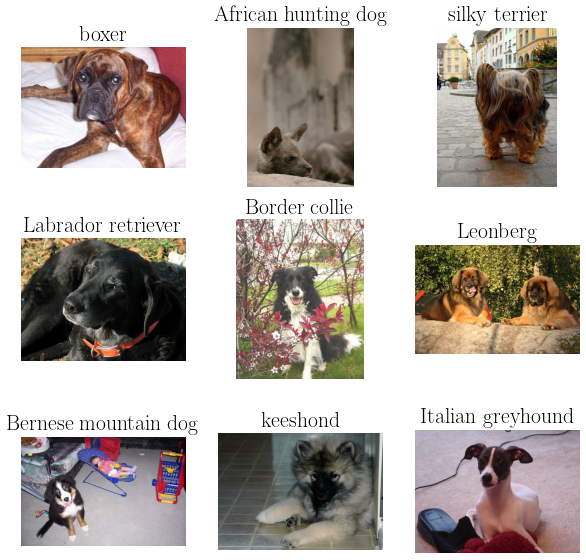

In [6]:
plt.figure(figsize=[10, 10])
for index, (img, label) in enumerate(test_ds_original.take(9)):
    class_name = loader.norm_class_names[label]
    plt.subplot(3, 3, index + 1); plt.imshow(img); plt.title(class_name)
    plt.axis("off")
save_fig("unscaled_dogs")
plt.show()

In [7]:
from tensorflow.keras.applications import xception
base_model = xception.Xception()
print(f"Layers in {base_model.name}: {len(base_model.layers)}")
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

Layers in xception: 134
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_b

In [8]:
base_model = xception.Xception(include_top=False)
print(f"Layers in {base_model.name} no top: {len(base_model.layers)}")
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

Layers in xception no top: 132
0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 

In [9]:
image, label = next(iter(train_ds_original))
print("Image shape: ", image.numpy().shape)
print("Label: ", label.numpy())
print("Values: ", image[0, 0])

Image shape:  (361, 500, 3)
Label:  22
Values:  tf.Tensor([124 113  83], shape=(3,), dtype=uint8)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomTranslation(
        width_factor=0.15,
        height_factor=0.15,
        fill_mode="nearest"
    ),
    layers.experimental.preprocessing.RandomZoom(
        width_factor=0.15,
        height_factor=0.15,
        fill_mode="nearest"
    )
])

def random_brightness(img):
    return tf.image.random_brightness(img, max_delta=0.3)

def preprocess(img, label, augment=False):
    if augment:
        img = random_brightness(img)
    resized = preprocessing.image.smart_resize(img, [img_height, img_width])
    final = xception.preprocess_input(resized)
    return final, label

def prepare(ds: tf.data.Dataset, augment=False):
    ds = ds \
        .map(partial(preprocess, augment=augment), num_parallel_calls=AUTOTUNE) \
        .batch(batch_size)
    if augment:
        ds = ds.map(lambda X, y: (data_augmentation(X), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds_original, augment=True)
val_ds = prepare(val_ds_original, augment=True)
test_ds = prepare(test_ds_original)

In [11]:
batch, label = next(iter(train_ds))
print("Image batch shape: ", batch.numpy().shape)
print("Label batch: ", label.numpy())
print("Preprocessed value: ", batch[0, 0, 0])

Image batch shape:  (32, 224, 224, 3)
Label batch:  [104  90  74  30  15 108  84  84  98  36  67  70  92  48 114 109  78  45
  78  57  71  86  41 116  99  25 114  40  31  91  22 118]
Preprocessed value:  tf.Tensor([-0.9616369 -0.8899164 -0.8787179], shape=(3,), dtype=float32)


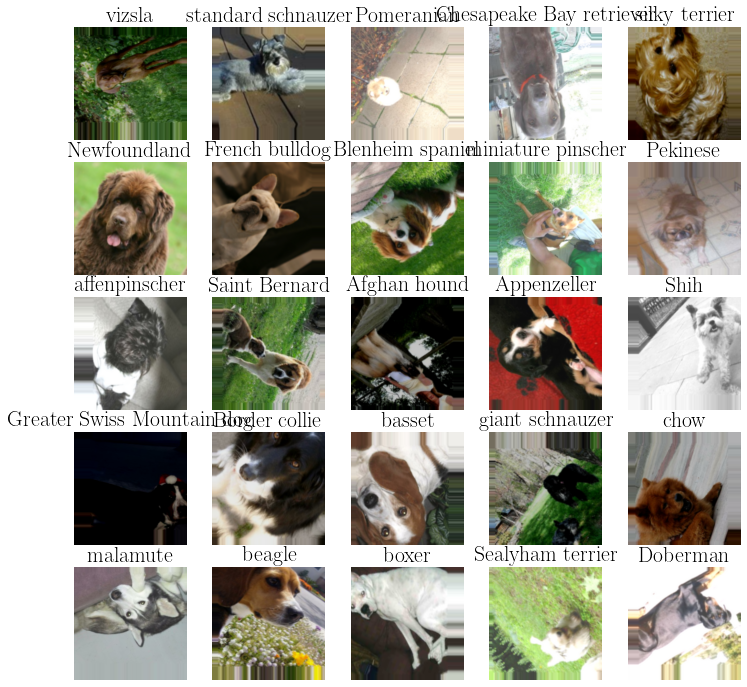

In [12]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_ds.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X_batch[i] / 2 + 0.5)
        plt.title(loader.norm_class_names[y_batch[i]])
        plt.axis("off")
plt.show()

In [13]:
for layer in base_model.layers:
    layer.trainable = False

In [14]:
from tensorflow.keras.models import Model

def build_model(base_model):
    headModel = base_model.output
    headModel = layers.GlobalAveragePooling2D()(headModel)
    headModel = layers.Dense(
        len(loader.class_names),
        activation='selu',
        kernel_initializer='lecun_normal',
        name="my_predictions")(headModel)

    model = Model(inputs=base_model.input, outputs=headModel)

    return model

model = build_model(base_model)

In [15]:
model.summary()

][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, None, None, 7 0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, None, None, 7 536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, None, None, 7 2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, None, None, 7 0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv3 (SeparableConv2 (None, None, None, 7 536536      block5_sepconv3_act[0][0]  

In [16]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=0.01)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath="models/checkpoints"
)

In [17]:
history = model.fit(train_ds, validation_data=val_ds, epochs=8)

Epoch 1/6
454/454 [==============================] - 57s 114ms/step - loss: 2.5850 - accuracy: 0.4142 - val_loss: 0.6088 - val_accuracy: 0.8185
Epoch 2/6
454/454 [==============================] - 51s 108ms/step - loss: 1.8198 - accuracy: 0.5291 - val_loss: 0.5211 - val_accuracy: 0.8409
Epoch 3/6
454/454 [==============================] - 53s 115ms/step - loss: 1.6740 - accuracy: 0.5550 - val_loss: 0.5083 - val_accuracy: 0.8460
Epoch 4/6
454/454 [==============================] - 51s 110ms/step - loss: 1.5804 - accuracy: 0.5733 - val_loss: 0.4975 - val_accuracy: 0.8475
Epoch 5/6
454/454 [==============================] - 52s 112ms/step - loss: 1.5351 - accuracy: 0.5826 - val_loss: 0.4822 - val_accuracy: 0.8529
Epoch 6/6
453/454 [============================>.] - ETA: 0s - loss: 1.5020 - accuracy: 0.5902

KeyboardInterrupt: 

In [18]:
for layer in base_model.layers:
    layer.trainable = True

In [19]:
optimizer = keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, decay=0.001, nesterov=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(
  monitor="loss",
  mode="min",
  patience=3,
  min_delta=0.01,
  verbose=1,
  restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(mlutils.get_run_logdir())

In [20]:
history = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[tensorboard_cb])

c:\Users\jens\main\learn\google_coral_ml\python\env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
Epoch 1/40
126/454 [=======>......................] - ETA: 2:02 - loss: 1.6176 - accuracy: 0.5766

KeyboardInterrupt: 

In [21]:
model.save("models/dog_v5.h5", overwrite=False)

In [22]:
batch_new = next(iter(test_ds))
X_new = batch_new[0]
y_new = batch_new[1]
print(X_new.shape)
print(y_new.shape)
print()
print("Predictions using original model and 'tf.nn.softmax'")
print("-----------------------------------")
pred = model.predict(X_new)
pred = tf.nn.softmax(pred, axis=1).numpy()
print(np.argmax(pred, axis=1))
print()
print("Predictions model with softmax layer model")
print("-----------------------------------")
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax(axis=1)])
pred = probability_model.predict(X_new)
print(np.argmax(pred, axis=1))
print()
print("Grounding Truth (labels)")
print("-----------------------------------")
print(y_new.numpy())

(32, 224, 224, 3)
(32,)

Predictions using original model and 'tf.nn.softmax'
-----------------------------------
[110  27  45  11 119  99  54  57  15  38  35 119  12  65  25  86  20 114
 110  62 108 115 118  26  68 115  10   9  40  39  20  70]

Predictions model with softmax layer model
-----------------------------------
[110  27  45  11 119  99  54  57  15  38  35 119  12  65  25  86  20 114
 110  62 108 115 118  26  68 115  10   9  40  39  20  70]

Grounding Truth (labels)
-----------------------------------
[110  27  47  11 119  97  54  57  15  38  35 119  12  65  25  86  21 114
 110  62 108 115 118  26  68 115  10   9  40  39  20  70]


In [28]:
model.evaluate(test_ds)

<PrefetchDataset shapes: ((None, None, None, None, None, 224, 224, None), (None, None, None, None, None)), types: (tf.float32, tf.int64)>
